In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

# Exponential function: $u(t,x)=exp(x-at)$

The function $u$ solves $u_t = -a u_x$ and $u_t= -a u$.

In [2]:
a = 3
nx, nt = (300, 200)
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)

u = np.exp(xv-a*tv)

dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0,drop_endpoints=False)._differentiate(u, dx)

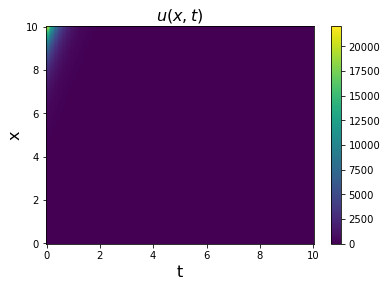

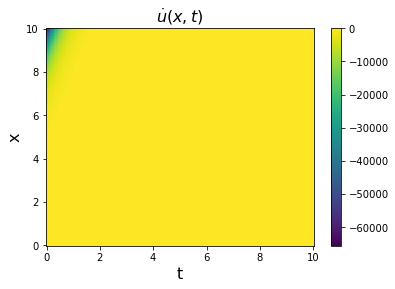

In [3]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

In [4]:
u = u.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=1, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.143 1 + -15.268 x0 + 12.250 x0_1
SR3 model, L0 norm: 


D:\programs\miniconda3\envs\tf-gpu\envs\pysindy\lib\site-packages\pysindy\optimizers\sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


(x0)' = 0.143 1 + -15.268 x0 + 12.250 x0_1
SR3 model, L1 norm: 


D:\programs\miniconda3\envs\tf-gpu\envs\pysindy\lib\site-packages\pysindy\optimizers\sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  warnings.warn(


(x0)' = 0.143 1 + -15.268 x0 + 12.250 x0_1
SSR model: 
(x0)' = -15.254 x0 + 12.235 x0_1
SSR (metric = model residual) model: 
(x0)' = -0.308 1 + -3.052 x0 + 0.049 x0_1
FROLs model: 
(x0)' = -3.003 x0


So, we clearly see that all models find the approximately correct solution, however they find different ones, which even look more complicated than the easiest ones in most cases. Also, they do not provide any information themselves that there might be an ambiguity problem, except for the "not converging" warning.

## Check the rank of the matrix, as we have non uniqueness for linear PDEs

We cannot directly check the matrix rank of $(u(t_i,x_j),u_x(t_i,x_j))(\mathbb{R}^{n\times m})^2$ as both are themselves already matrices or even higher dimensional linear forms. Linear dependence of the function is equal to linear dependence of the matrices, which translates to linear dependence of the vectorized versions of $(u(t_i,x_j),u_x(t_i,x_j))\in\mathbb{R}^{nm\times2}$.

In [5]:
from numpy.linalg import matrix_rank, svd

In [6]:
ux = ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux.flatten()
g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
matrix_rank(g), svd(g, compute_uv=False)

(2, array([2.40049017e+05, 1.62391338e+01]))

In [7]:
np.linalg.norm(u_flat - u_x_flat)

34.39464458346127

In [10]:
distance_svs = []
fd_orders = range(2, 8)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)

    u_flat, u_x_flat = u.flatten(), ux.flatten()
    features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
    svs = svd(features, compute_uv=False)
    distance_svs.append(svs[-1])

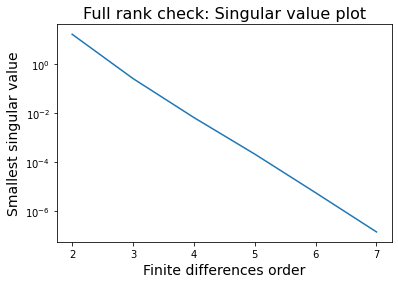

In [19]:
plt.plot(range(2,8), distance_svs)
plt.title('Full rank check: Singular value plot', size=16)
plt.xlabel('Finite differences order', size=14)
plt.ylabel('Smallest singular value', size=14)
plt.yscale('log')